In [1]:
options(warn=-1)

In [2]:
library('edgeR')
library('limma')
library('dplyr')

Loading required package: limma


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [19]:
p_val_thres <- 0.1

In [20]:
rds_path = '/tmp/work/RCproject/gene_lists.rds'
gene_lists<- readRDS(rds_path)
model_gene_list <- gene_lists$'de_intersect_plus_bulk_genes'
length(model_gene_list)

[1] 366

In [21]:
file_path = '/tmp/work/RCproject/GEO_singlecellexperiment.rds'
sce <- readRDS(file_path)
sce <- sce[, colData(sce)$Response != "partial"]

In [22]:
train_samples <- readLines("train_samples.txt")
head(train_samples)
sce <- sce[,train_samples]
sce

[1] "GSM5732588_GSE190826"  "GSM4523147_GSE150082"  "GSM6390460_GSE209746" 
[4] "GSM1103637_GSE45404-2" "GSM6390447_GSE209746"  "GSM5732586_GSE190826"

class: SingleCellExperiment 
dim: 12165 369 
metadata(0):
assays(3): counts logcounts scalelogcounts
rownames(12165): A1CF A2M ... ZZEF1 ZZZ3
rowData names(5): SYMBOL ENTREZID ENSEMBL gene_id gene_name
colnames(369): GSM5732588_GSE190826 GSM4523147_GSE150082 ...
  GSM5732574_GSE190826 GSM4304768_GSE145037
colData names(6): Response TRG ... Platform batch
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [23]:
all_data_sets <- sce
de4_data_sets <- sce[, colData(sce)$Platform %in% c("GPL13497","GPL14951","GPL15207","GPL6102")]
rna_seq_data_sets <- sce[, colData(sce)$Platform %in% c("GPL16791","GPL20301")]

print('All')
table(colData(all_data_sets)$Response)
print('de4')
table(colData(de4_data_sets)$Response)
print('RNA_seq')
table(colData(rna_seq_data_sets)$Response)

[1] "All"



 no yes 
241 128 

[1] "de4"



 no yes 
 56  30 

[1] "RNA_seq"



 no yes 
131  46 

In [24]:
get_diff_genes <- function(input_sce){
    response <- colData(input_sce)$Response
    batch <- colData(input_sce)$batch
    print('current sample layout:')
    print(table(colData(input_sce)$batch))
    counts <- assay(input_sce, "scalelogcounts")
    batch <- factor(unlist(batch))
    response <- factor(unlist(response))
    plotMDS(counts, col = as.numeric(response))
    mm <- model.matrix(~0 + response + batch)
    fit <- lmFit(counts, mm)
    contr <- makeContrasts(responseyes - responseno, levels = colnames(coef(fit)))
    tmp <- contrasts.fit(fit, contr)
    tmp <- eBayes(tmp)
    top.table <- topTable(tmp, sort.by = "P", n = Inf)
    print(head(top.table, 20))
    print(length(which(top.table$P.Value < p_val_thres)))
    sig_genes <- rownames(top.table[top.table$P.Value < p_val_thres,])
    return(sig_genes)
}

[1] "current sample layout:"

    GSE133057     GSE145037     GSE150082     GSE190826     GSE209746 
           22            30            27            89            88 
GSE45404_GPL1 GSE45404_GPL2      GSE93375      GSE94104 
           37            39            17            20 
             logFC      AveExpr         t      P.Value  adj.P.Val           B
DCP1B    0.2916242 -0.179289749  4.730430 3.212239e-06 0.03907689  3.75535907
ATG4C    0.2155290 -0.388621556  4.130403 4.497188e-05 0.19367866  1.59369550
PIGK     0.2273835 -0.158696884  4.110371 4.886633e-05 0.19367866  1.52602448
GMEB2   -0.1903038  0.103990069 -4.045949 6.368390e-05 0.19367866  1.31040678
LRIG3    0.2833632  0.327650029  3.938913 9.813808e-05 0.20750695  0.95896522
CEP57    0.2420683  0.264410584  3.928394 1.023462e-04 0.20750695  0.92488762
SMOX    -0.2378041 -0.149769756 -3.831275 1.501540e-04 0.21946755  0.61416805
LAMA5   -0.3590011  0.873992848 -3.752948 2.033777e-04 0.21946755  0.36873698
TPD52L2 -0.2

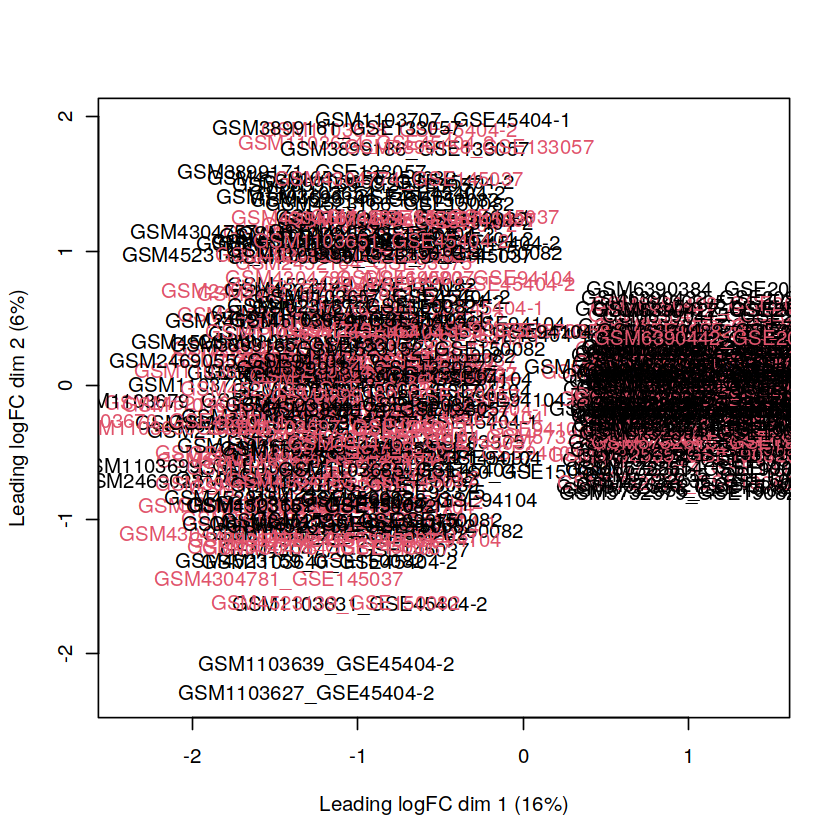

              logFC      AveExpr         t      P.Value adj.P.Val         B
ARHGAP27 -0.5977496  0.042746717 -4.517991 1.992902e-05 0.2424365 -1.624349
TSNAX     0.4452534 -0.003245752  3.804933 2.660601e-04 0.7121724 -2.442736
C6orf89   0.5037625  0.079470955  3.702787 3.773828e-04 0.7121724 -2.554436
RNF11     0.5693110 -0.024919289  3.692134 3.912620e-04 0.7121724 -2.565992
TTC29     1.6979972  0.150884618  3.581203 5.677296e-04 0.7121724 -2.685234
PLA2G15  -0.5014389 -0.080370205 -3.565471 5.981636e-04 0.7121724 -2.701979
SLC7A4   -1.0337817  0.249722073 -3.502748 7.355596e-04 0.7121724 -2.768322
BRPF1    -0.3911159 -0.006778108 -3.488932 7.695982e-04 0.7121724 -2.782845
PMEL     -0.5462829  0.030947436 -3.458018 8.512209e-04 0.7121724 -2.815216
PPP4R3B   0.4347419  0.015140156  3.430776 9.298553e-04 0.7121724 -2.843599
BLVRA     0.7441156 -0.098709273  3.418062 9.688566e-04 0.7121724 -2.856801
B3GALNT2  0.5685052  0.063942001  3.362665 1.157477e-03 0.7121724 -2.913976
ZNF106    0.

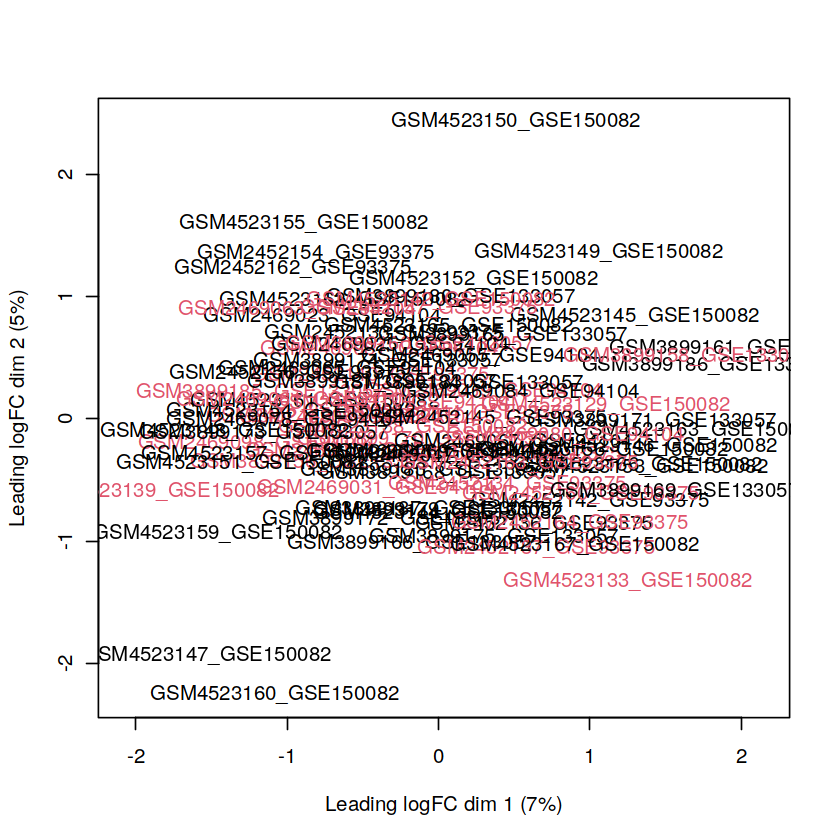

             logFC     AveExpr         t      P.Value adj.P.Val          B
PRSS3   -0.2350806 -0.12754716 -4.170129 4.738147e-05 0.5763956  1.4769211
MBIP     0.2152783 -0.35270464  3.945568 1.142146e-04 0.6947106  0.7770651
SLC2A1  -0.3827785  1.08778396 -3.766280 2.246409e-04 0.9109187  0.2409910
CDYL    -0.0898229  0.40373654 -3.638026 3.592138e-04 0.9661057 -0.1297923
CYP4V2   0.1800865  0.38755091  3.582163 4.390254e-04 0.9661057 -0.2879208
DDIT4   -0.2553270 -0.24564340 -3.559168 4.765009e-04 0.9661057 -0.3524122
ZNF300   0.2447961 -0.89388775  3.513423 5.601717e-04 0.9734984 -0.4796626
AGO4     0.1370627  0.53141215  3.456396 6.838248e-04 0.9842460 -0.6363310
NDST3    0.1421877 -1.39118937  3.378259 8.951553e-04 0.9842460 -0.8474331
ESR2     0.1500251 -0.66971115  3.356948 9.625965e-04 0.9842460 -0.9042859
ZNF624   0.1029408 -0.95443156  3.322027 1.083462e-03 0.9842460 -0.9967811
INHBB   -0.2132955 -1.25488925 -3.313636 1.114539e-03 0.9842460 -1.0188796
C7orf31  0.1296429 -0.981

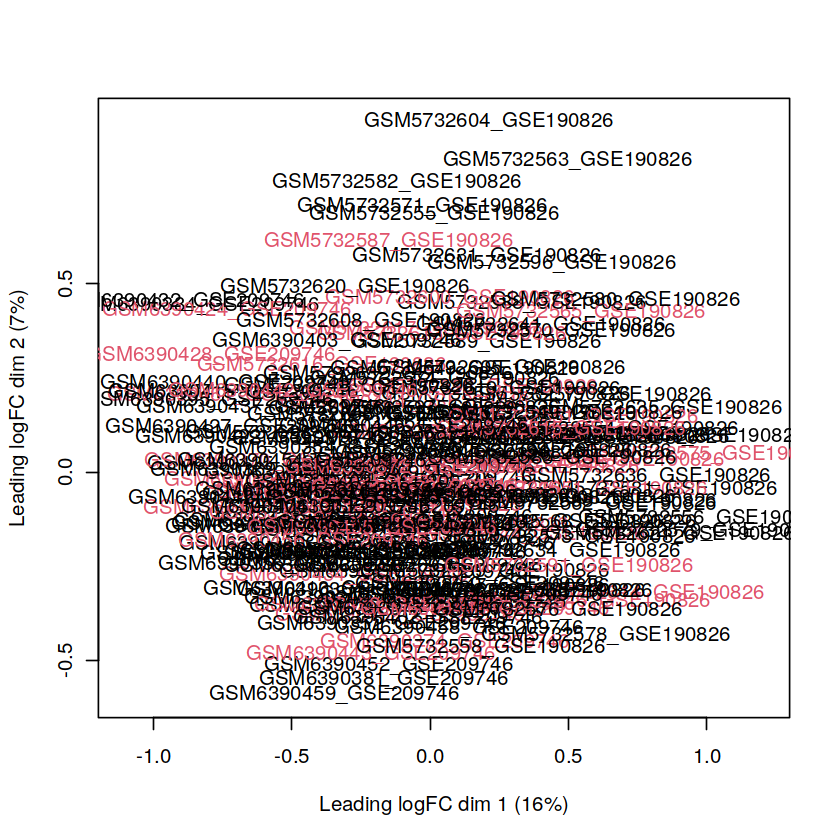

In [25]:
DE_alldatasets <- get_diff_genes(all_data_sets)
DE_4datasets <- get_diff_genes(de4_data_sets)
DE_bulkDatasets <- get_diff_genes(rna_seq_data_sets)

In [26]:
de_intersect_plus_bulk_genes <- intersect(union(DE_bulkDatasets,DE_4datasets),DE_alldatasets)
saveRDS(de_intersect_plus_bulk_genes,'ann_gene_set.rds')

In [27]:
length(de_intersect_plus_bulk_genes)

[1] 911

In [15]:
#de_all should have 962 total...